# Exploring iterative Krylov subspace methods, with an emphasis on their performance in finite precision

<p align='right'> Mohamed Amine Ghouila - Truong Minh Tue</p>
<p align='right'> Supervisors: Paul Mycek - Luc Giraud - Selime Gurol - Carola Kruse</p>


---
This project is carried out as part of the course of 4GMM - INSA Toulouse. This notebook provide the code employed in our project that was used to obtain the results in the associated report.

Notation: The problem that the methods try to solve is of the form $Ax=b$ where $A$ is a matrix and $x,b$ are vectors. If not specified, the variables would be named accordingly.

Notation:
- FOM: Full Orthogonalisation Method
- CG : Conjugate Gradient Method
- GMRES : Generalized Minimal Residual Method

### Modules
In this section we define the necessary modules. First we define the main procedures for the Arnoldi process as well as the FOM, CG, GMRES algorithms.

In [ ]:
import numpy as np
import scipy as sp
import numpy.linalg as npl
import numpy.random as npr
import scipy.linalg as spl
import scipy.sparse as scs
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def Arnoldi_Step(A,V,H, re_ortho=True):
    n,m = np.shape(V)
    h = np.zeros((m+1,1))
    v = np.zeros((n,1))

    # Gram-Schmidt
    # TODO: option to choose
    w = A @ V[:,-1]
    for k in range(1+re_ortho):
      for i in range(m):
        temp = w.T @ V[:,i]
        h[i, 0] += temp
        w -= temp * V[:,i]
    h[m,0] = npl.norm(w)

    # Add to H
    if H is None:
        H = h
    else:
        l = np.zeros((1,m-1))
        H = np.concatenate((H,l),axis = 0)
        H = np.concatenate((H,h),axis = 1)

    # Add to V
    w = w/h[m,0]
    v[0:n,0] = w
    V = np.concatenate((V,v),axis = 1)

    return V,H

In [ ]:
def FOM(A, b, x0=None, tol=1e-12, max_niter=200, re_ortho=True, info=False):
  n = len(b)
  if x0 is None:
    x0 = np.zeros((n, 1))

  r = b - A.dot(x0)
  beta = npl.norm(r)
  true_res = []
  iterative_residual = []
  ortho_loss = []
  algo_stop_index = []
  sigma_min = []
  backward_error = []
  cond = []
  min_backward = []

  V = r / beta
  H = None
  niter = 1

  while (niter<max_niter):
    # Arnoldi Step
    V,H = Arnoldi_Step(A, V, H, re_ortho=re_ortho)

    # Calculate y and x
    betaE1 = np.zeros((niter,1))
    betaE1[0] = beta
    y = npl.solve(H[:-1,:], np.eye(niter)) @ betaE1
    x = x0 + V[:,:-1] @ y

    # Tracking
    # Uncomment to track these types of statistics

    # vrai_res = npl.norm(b - A@x)
    # true_res.append(vrai_res / npl.norm(b))
    # iterative_residual.append(abs(H[-1,-1])*abs(y[-1]) / npl.norm(b))
    ortho_loss.append(npl.norm(np.eye(niter+1) - V.T@V, ord=2))
    # algo_stop_index.append(H[-1,-1])
    # sigma_min.append(min(abs(npl.svd(V)[1])))
    backward_error.append(npl.norm(b - A@x) /
     (npl.norm(A, ord=2) * npl.norm(x) + npl.norm(b)))
    min_backward.append(np.min(backward_error))
    # verif_Arnoldi = npl.norm(A@V[:,:-1] - V@H)
    cond.append(npl.cond(V))

    # Print to keep track of progress
    if info:
      if niter<=6:
        plt.imshow(np.log(np.abs(H[:-1,:])))
        # plt.imshow(V.T@V)
        plt.colorbar()
        plt.show()

    # Stop condition: h_niter,niter+1 = 0 (sufficiently small)
    # if H[-1,-1]<tol:
    if backward_error[-1]<tol:
      print(f'Algo FOM stopped at iter {niter}!')
      break
    niter+=1

  result = {
        'x': x,
        'true_res': true_res,
        'iterative_residual': iterative_residual,
        'ortho_loss': ortho_loss,
        'algo_stop_index': algo_stop_index,
        'sigma_min': sigma_min,
        'backward_error': backward_error,
        'V': V,
        'cond': cond,
        'min_backward':min_backward
    }
  return result

In [ ]:
def GMRES(A, b, x0=None, tol=1e-12, max_niter=200, info=False):
  n = len(b)
  if x0 is None:
    x0 = np.zeros((n, 1))

  r = b - A.dot(x0)
  beta = npl.norm(r)
  true_res = []
  iterative_residual = []
  ortho_loss = []
  algo_stop_index = []
  sigma_min = []
  backward_error = []
  cond = []

  V = r / beta
  H = None
  niter = 1

  while (niter<max_niter):
    # Arnoldi Step
    V,H = Arnoldi_Step(A, V, H)

    # Calculate y and x
    betaE1 = np.zeros((niter+1,1))
    betaE1[0] = beta
    y = npl.lstsq(H,betaE1)[0]
    y = y.reshape(niter,1)
    x = x0 + V[:,:-1] @ y

    # Tracking
    # Uncomment to track these types of statistics

    # vrai_res = npl.norm(b - A@x)
    # true_res.append(vrai_res / npl.norm(b))
    # iterative_residual.append(abs(H[-1,-1])*abs(y[-1]) / npl.norm(b))
    ortho_loss.append(npl.norm(np.eye(niter+1) - V.T@V, ord=2))
    # algo_stop_index.append(H[-1,-1])
    # sigma_min.append(min(abs(npl.svd(V)[1])))
    backward_error.append(npl.norm(b - A@x) /
     (npl.norm(A, ord=2) * npl.norm(x) + npl.norm(b)))
    # verif_Arnoldi = npl.norm(A@V[:,:-1] - V@H)
    cond.append(npl.cond(V))

    # Print to keep track of progress
    if info:
      if niter<=6:
        plt.imshow(V.T@V)
        plt.colorbar()
        plt.show()

    # Stop condition: h_niter,niter+1 = 0 (sufficiently small)
    # if H[-1,-1]<tol:
    if backward_error[-1]<tol:
      print(f'Algo GMRES stopped at iter {niter}!')
      break
    niter+=1

  result = {
        'x': x,
        'true_res': true_res,
        'iterative_residual': iterative_residual,
        'ortho_loss': ortho_loss,
        'algo_stop_index': algo_stop_index,
        'sigma_min': sigma_min,
        'backward_error': backward_error,
        'V': V,
        'cond': cond
    }
  return result

In [ ]:
def ConjuGrad(A, b, x0=None,
              tol=1e-12,
              max_niter=200,
              info=False,
              re_ortho=True):
  n = len(b)
  if x0 is None:
    x0 = np.zeros((n, 1))
  x = np.copy(x0)
  r0 = b - A.dot(x0)
  p = r0
  Ap = A@p
  r_j = r0
  niter = 1

  R = np.array(r0)
  R_norm = np.array(r0)/npl.norm(r0)
  V_CG = R_norm
  backward_error = []
  ortho_loss = []
  cond = []
  x_mat = []
  while (niter<max_niter):
    alpha = (r_j.T@r_j) / (Ap.T@p)
    x = x + alpha * p
    r_j_new = r_j - alpha * Ap
    beta = r_j_new.T@r_j_new / (r_j.T@r_j)
    p = r_j_new + beta * p
    # Gram-Schmidt
    if re_ortho:
      # r_j_new -=  r_j * (r_j_new.T @ r_j)
      for i in range(niter):
        temp = R_norm[:,-i-1] * (r_j_new.T @ R_norm[:,-i-1])
        r_j_new -=  temp.reshape(n,1)
    # Update
    Ap = A@p
    r_j = r_j_new
    # print(r_j.T@r_j)

    # Storing
    R = np.concatenate((R,r_j_new),axis = 1)
    norm = npl.norm(r_j_new)
    if norm!=0:
      r_j_new_norm = r_j_new.copy() / npl.norm(r_j_new)
    else:
      r_j_new_norm = r_j_new.copy()
    R_norm = np.concatenate((R_norm,r_j_new_norm),axis = 1)
    alternate = (-1)**(niter%2)
    V_CG = np.concatenate((V_CG,r_j_new_norm*alternate),axis=1)

    # Tracking
    ortho_loss.append(npl.norm(np.eye(niter+1) - R_norm.T@R_norm))
    backward_error.append(npl.norm(b - A@x) /
     (npl.norm(A, ord=2) * npl.norm(x) + npl.norm(b)))
    # cond.append(npl.cond(R_norm))
    x_mat.append(x)

    # Print to keep track of progress
    if info:
      if niter<=6:
        plt.imshow(R_norm.T@R_norm)
        plt.colorbar()
        plt.show()

    # Stop condition: h_niter,niter+1 = 0 (sufficiently small)
    if backward_error[-1]<tol:
      print(f'Algo Conjugate Gradient stopped at iter {niter}!')
      break
    niter+=1

  result = {
        'x': x,
        'backward_error': backward_error,
        'ortho_loss': ortho_loss,
        'R': R,
        'R_norm': R_norm,
        'V_CG': V_CG,
        'cond': cond,
        'x_mat': x_mat
    }
  return result

Next we define functions to generate matrices in several different ways.

In [ ]:
# Generate a sparse random matrix with eigenvalues
# having a gaussien distribution (m, sigma)
# and density d
def RandMat(n,m = 2,sigma = 0.5):
    ev = np.sqrt(sigma)*npr.randn(n) + m
    ev = np.abs(ev)
    D = np.diag(ev,0)
    A = np.random.rand(n,n)
    Tri = np.tril(A, k=-1)
    # A = Tri + D + Tri.T
    A = Tri + D

    cond = npl.cond(A)
    return A, cond

def RandMatSPD(n, eig, seed=42):
  np.random.seed(seed)
  Q, R = npl.qr(npr.rand(n,n))
  D = np.diag(eig, 0)
  A = Q.T @ D @ Q
  return A, npl.cond(A)

def RandMatStrakos(n, seed=42):
  # Diagonal Strakos matrix: Equation (2.8) from Carson et al. 2024.
  np.random.seed(seed)
  Q, R = npl.qr(npr.rand(n,n))
  lmin = .1
  lmax = 100
  rho = 0.9 # Determines distribution of the eigenvalues
  eig = []
  for i in range(n):
    eig.append(lmin + ((i-1)/(n-1))*(lmax - lmin)*rho**(n-i))
  A = Q @ np.diag(eig, 0) @ Q.T
  return A, npl.cond(A)

Here is a visualization of the matrices generated by different methods (RandMatSPD vs RandMatStrakos)

100.00000000000092


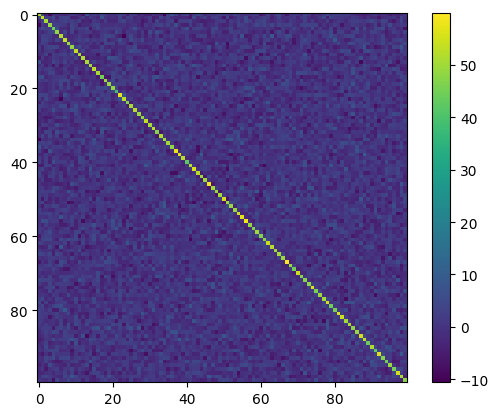

In [ ]:
N = 100
A, cond = RandMatSPD(N, np.linspace(1,100,N), seed=20)
print(cond)
plt.imshow(A)
plt.colorbar()

891.2570642561625


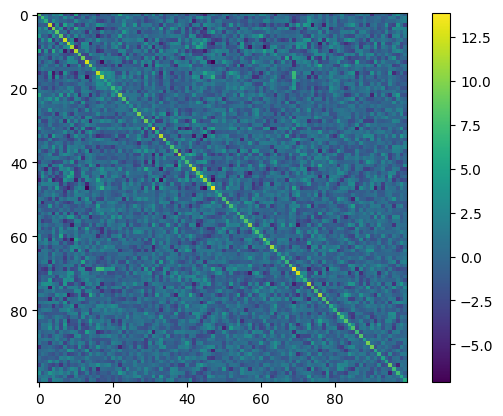

In [ ]:
N = 100
A, cond = RandMatStrakos(N, seed=10)
print(cond)
plt.imshow(A)
plt.colorbar()

### FOM
In this section we provide the code to apply FOM on a matrice generated in one of the above methods, and plot the tracking of various statistics related to the accuracy and robustness of the algorithm.

Algo FOM stopped at iter 61!


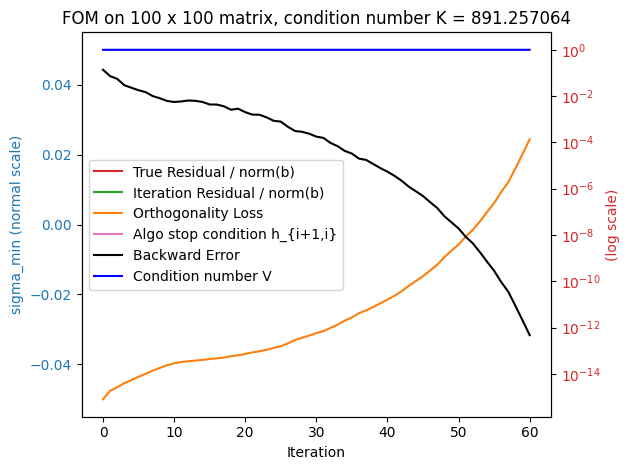

In [ ]:
# Parameters and initialisation
N = 100
# Generate with Strakos
A, cond = RandMatStrakos(N, seed=10)
# A, cond = RandMatSPD(N, np.linspace(1,100,N), seed=20)
x_exact = np.random.random(N)
b = A @ x_exact
b = b.reshape(-1,1)

# Apply algo
out_FOM = FOM(A,b,max_niter = N+5, info=False, re_ortho=False)

# Plotting =====================================================================
# Create the first plot (left y-axis, normal scale)
fig, ax1 = plt.subplots()

# Create the first plot (left y-axis, normal scale)
color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('sigma_min (normal scale)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(out_FOM['sigma_min'], label='Sigma_min of V')

# Create the second plot (right y-axis, log scale)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('(log scale)', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

ax2.plot(out_FOM['true_res'], color='tab:red', label='True Residual / norm(b)')
ax2.plot(out_FOM['iterative_residual'], color='tab:green', label='Iteration Residual / norm(b)')
ax2.plot(out_FOM['ortho_loss'], color='tab:orange', label='Orthogonality Loss')
ax2.plot(out_FOM['algo_stop_index'], color='tab:pink', label='Algo stop condition h_{i+1,i}')
ax2.plot(out_FOM['backward_error'], color='black', label='Backward Error')
ax2.plot(out_FOM['cond'], color='blue', label='Condition number V')


# Add a common title
plt.title("FOM on %i x %i matrix, condition number K = %f" % (N, N, cond))

plt.legend()
plt.tight_layout()
plt.show()

### FOM vs CG vs GMRES
In this section we provide the code to apply FOM, CG and GMRES on a matrice generated in one of the above methods, as well as plot the tracking of various statistics related to the accuracy and robustness of the algorithms for comparison.

Algo FOM stopped at iter 30!
Algo GMRES stopped at iter 30!


<ipython-input-4-596ba81c6b56>:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y = npl.lstsq(H,betaE1)[0]
<ipython-input-5-eb0c1729e366>:27: RuntimeWarning: invalid value encountered in divide
  beta = r_j_new.T@r_j_new / (r_j.T@r_j)
<ipython-input-10-1f1c0cc78193>:64: RuntimeWarning: divide by zero encountered in log
  im = axs[1,1].imshow(np.log(np.abs(V_CG.T@V_CG)))


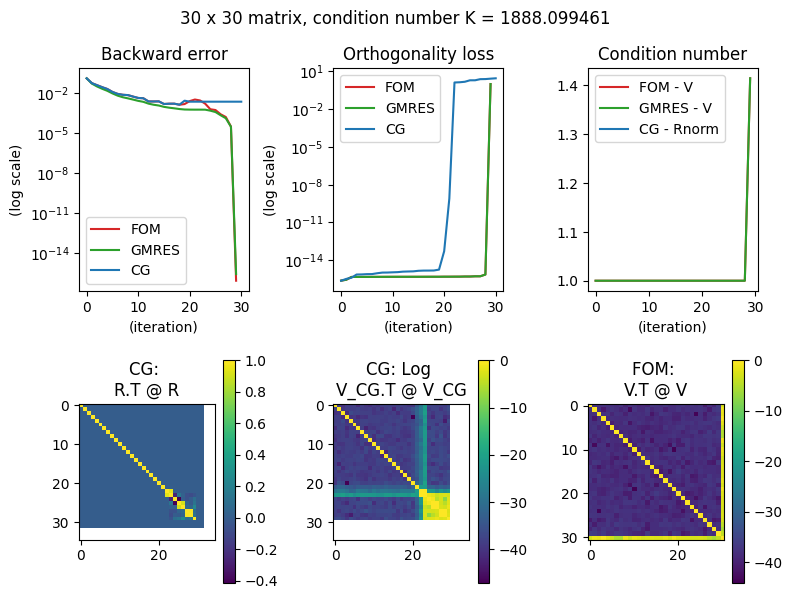

In [ ]:
# Parameters and initialisation
N = 30
# A, cond = RandMatSPD(N, np.linspace(1,100,N), seed=10)
A, cond = RandMatStrakos(N, seed=10)

x_exact = np.random.random(N)
b = A @ x_exact
b = b.reshape(-1,1)

# Apply algo
out_FOM = FOM(A,b,max_niter = N+5, info=False)
# x, true_res, iterative_residual, ortho_loss, algo_stop_index, sigma_min, backward_error, V = out_FOM
out_GMRES = GMRES(A,b,max_niter = N+5, info=False)
# x, true_res, iterative_residual, ortho_loss, algo_stop_index, sigma_min, backward_error, V = out_GMRES
out_ConjuGrad = ConjuGrad(A,b,max_niter = N+5, info=False)
# x, backward_error, ortho_loss, R, AP, R_norm, V_CG = out_ConjuGrad


# Plotting =====================================================================
fig, axs = plt.subplots(2, 3, figsize=(8, 6))

# Plot on the 1 subplot
axs[0,0].plot(out_FOM['backward_error'], color='tab:red', label='FOM')
axs[0,0].plot(out_GMRES['backward_error'], color='tab:green', label='GMRES')
axs[0,0].plot(out_ConjuGrad['backward_error'], color='tab:blue', label='CG')
axs[0,0].set_title("Backward error")
axs[0,0].set_ylabel('(log scale)')
axs[0,0].tick_params(axis='y')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel('(iteration)')
axs[0,0].legend()

# Plot on the 2 subplot
axs[0,1].plot(out_FOM['ortho_loss'], color='tab:red', label='FOM')
axs[0,1].plot(out_GMRES['ortho_loss'], color='tab:green', label='GMRES')
axs[0,1].plot(out_ConjuGrad['ortho_loss'], color='tab:blue', label='CG')
axs[0,1].set_title("Orthogonality loss")
axs[0,1].set_ylabel('(log scale)')
axs[0,1].tick_params(axis='y')
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel('(iteration)')
axs[0,1].legend()

# Plot on the 3 subplot
axs[0,2].plot(out_FOM['cond'], color='tab:red', label='FOM - V')
axs[0,2].plot(out_GMRES['cond'], color='tab:green', label='GMRES - V')
axs[0,2].plot(out_ConjuGrad['cond'], color='tab:blue', label='CG - Rnorm')
axs[0,2].set_title("Condition number")
# axs[0,2].set_ylabel('(log scale)')
axs[0,2].tick_params(axis='y')
# axs[0,2].set_yscale('log')
axs[0,2].set_xlabel('(iteration)')
axs[0,2].legend()

# Plot on the 4 subplot
R_norm = out_ConjuGrad['R_norm']
im = axs[1,0].imshow(R_norm.T@R_norm)
# im = axs[1,0].imshow(R_norm.T@R_norm)
axs[1,0].set_title("CG: \nR.T @ R")
fig.colorbar(im, ax=axs[1,0])

# Plot on the 5 subplot
V_CG = out_ConjuGrad['V_CG']
im = axs[1,1].imshow(np.log(np.abs(V_CG.T@V_CG)))
axs[1,1].set_title("CG: Log \nV_CG.T @ V_CG")
# fig.colorbar(im, ax=axs[1,1], pad=.2)
fig.colorbar(im, ax=axs[1,1])

# Plot on the 6 subplot
V = out_FOM['V']
im = axs[1,2].imshow(np.log(np.abs(V.T@V)))
axs[1,2].set_title("FOM: \nV.T @ V")
fig.colorbar(im, ax=axs[1,2])


# Hide the empty slot
# axs[0, 2].axis('off')

# Adjust layout and display
plt.suptitle("%i x %i matrix, condition number K = %f" % (N, N, cond))
plt.tight_layout()
plt.show()

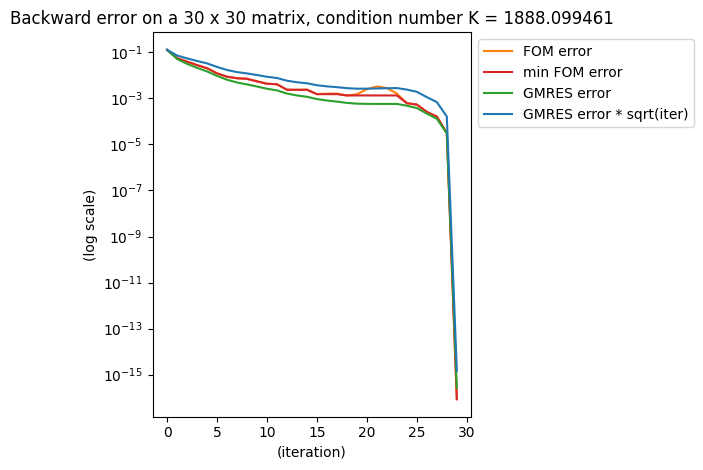

In [ ]:
# Parameters and initialisation
N = 30
# A, cond = RandMatSPD(N, np.linspace(1,100,N), seed=10)
A, cond = RandMatStrakos(N, seed=10)
x_exact = np.random.random(N)
b = A @ x_exact
b = b.reshape(-1,1)

# Plot ==================================================================
fig = plt.figure()
GMRES_upper_res = [out_GMRES['backward_error'][i]*np.sqrt(i+1)
                    for i in range(len(out_GMRES['backward_error']))]

plt.plot(out_FOM['backward_error'], '-', color='tab:orange', label='FOM error')
plt.plot(out_FOM['min_backward'], '-', color='tab:red', label='min FOM error')
plt.plot(out_GMRES['backward_error'],'-', color='tab:green', label='GMRES error')
plt.plot(GMRES_upper_res, '-', color='tab:blue', label='GMRES error * sqrt(iter)')

plt.yscale('log')
plt.ylabel('(log scale)')
plt.xlabel('(iteration)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Backward error on a %i x %i matrix, condition number K = %f" % (N, N, cond))
plt.tight_layout()

## FOM Re-orthogonalisation
In this section we provide the code to apply FOM with and without re-orthogonalisation on a matrice generated in one of the above methods, and plot the tracking of various statistics related to the accuracy and robustness of the algorithms for comparison.

Algo FOM stopped at iter 66!
Algo FOM stopped at iter 66!


<ipython-input-12-a29f84d65b8a>:56: RuntimeWarning: divide by zero encountered in log
  im = axs[1,1].imshow(np.log(np.abs(V.T@V)))


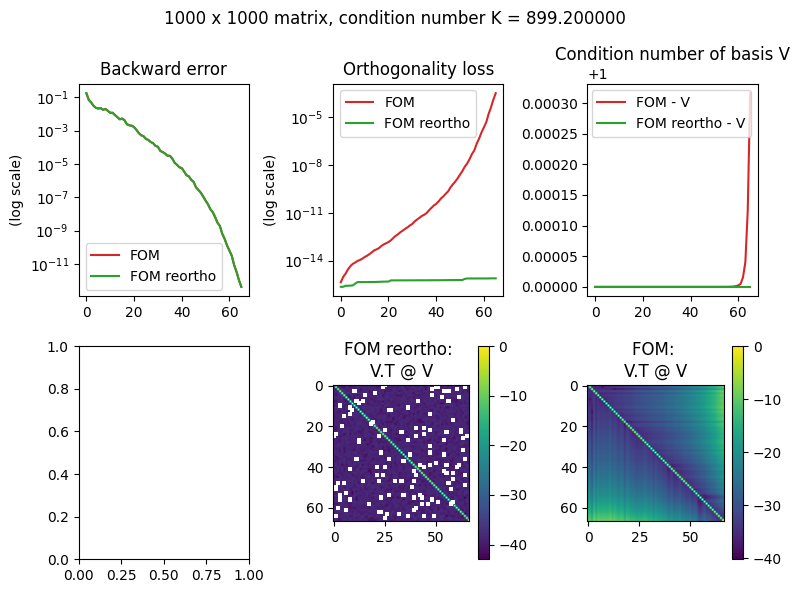

In [ ]:
# Parameters and initialisation
N = 1000
# A, cond = RandMatSPD(N, np.linspace(1,100,N), seed=10)
A, cond = RandMatStrakos(N, seed=10)

x_exact = np.random.random(N)
b = A @ x_exact
b = b.reshape(-1,1)

# Apply algo
out_FOM = FOM(A,b,max_niter = N+5, info=False, re_ortho=False)
# x, true_res, iterative_residual, ortho_loss, algo_stop_index, sigma_min, backward_error, V = out_FOM
out_FOM_reortho = FOM(A,b,max_niter = N+5, info=False, re_ortho=True)
# x, true_res, iterative_residual, ortho_loss, algo_stop_index, sigma_min, backward_error, V = out_FOM


# Plotting =====================================================================
fig, axs = plt.subplots(2, 3, figsize=(8, 6))

# Plot on the 1 subplot
axs[0,0].plot(out_FOM['backward_error'], color='tab:red', label='FOM')
axs[0,0].plot(out_FOM_reortho['backward_error'], color='tab:green', label='FOM reortho')
axs[0,0].set_title("Backward error")
axs[0,0].set_ylabel('(log scale)')
axs[0,0].tick_params(axis='y')
axs[0,0].set_yscale('log')
axs[0,0].legend()

# Plot on the 2 subplot
axs[0,1].plot(out_FOM['ortho_loss'], color='tab:red', label='FOM')
axs[0,1].plot(out_FOM_reortho['ortho_loss'], color='tab:green', label='FOM reortho')
axs[0,1].set_title("Orthogonality loss")
axs[0,1].set_ylabel('(log scale)')
axs[0,1].tick_params(axis='y')
axs[0,1].set_yscale('log')
axs[0,1].legend()

# Plot on the 3 subplot
axs[0,2].plot(out_FOM['cond'], color='tab:red', label='FOM - V')
axs[0,2].plot(out_FOM_reortho['cond'], color='tab:green', label='FOM reortho - V')
axs[0,2].set_title("Condition number of basis V")
# axs[0,2].set_ylabel('(log scale)')
axs[0,2].tick_params(axis='y')
# axs[0,2].set_yscale('log')
axs[0,2].legend()

# # Plot on the 4 subplot
# R_norm = out_ConjuGrad['R_norm']
# im = axs[1,0].imshow(np.log(np.abs(R_norm.T@R_norm)))
# # im = axs[1,0].imshow(R_norm.T@R_norm)
# axs[1,0].set_title("CG: \nR.T @ R")
# fig.colorbar(im, ax=axs[1,0])

# Plot on the 5 subplot
V = out_FOM_reortho['V']
im = axs[1,1].imshow(np.log(np.abs(V.T@V)))
axs[1,1].set_title("FOM reortho: \nV.T @ V")
fig.colorbar(im, ax=axs[1,1])

# Plot on the 6 subplot
V = out_FOM['V']
im = axs[1,2].imshow(np.log(np.abs(V.T@V)))
axs[1,2].set_title("FOM: \nV.T @ V")
fig.colorbar(im, ax=axs[1,2])

# Hide the empty slot
# axs[0, 2].axis('off')

# Adjust layout and display
plt.suptitle("%i x %i matrix, condition number K = %f" % (N, N, cond))
plt.tight_layout()
plt.show()

## CG Re-orthogonalisation
In this section we provide the code to apply CG with and without re-orthogonalisation on a matrice generated in one of the above methods, and plot the tracking of various statistics related to the accuracy and robustness of the algorithms for comparison.

<ipython-input-5-eb0c1729e366>:27: RuntimeWarning: invalid value encountered in divide
  beta = r_j_new.T@r_j_new / (r_j.T@r_j)


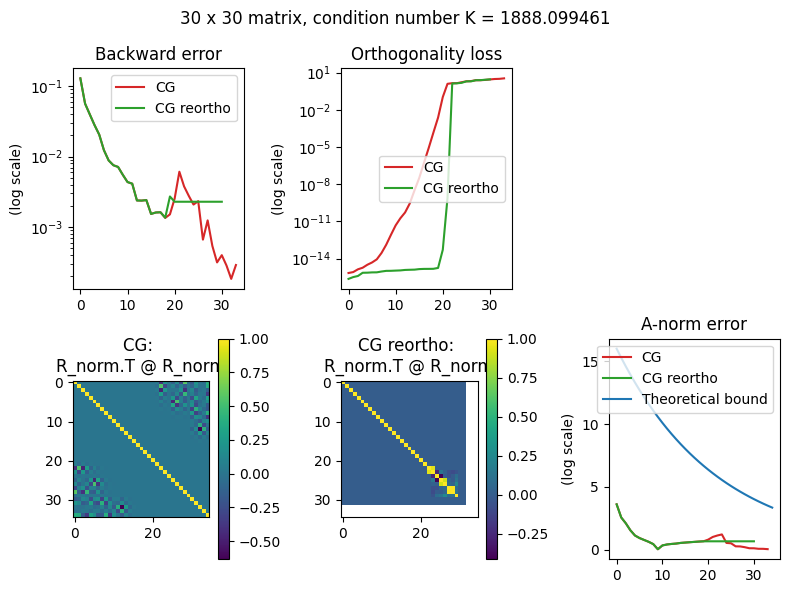

In [ ]:
# Parameters and initialisation
N = 30
# A, cond = RandMatSPD(N, np.linspace(1,100,N), seed=10)
A, cond = RandMatStrakos(N, seed=10)

x_exact = np.random.random(N)
b = A @ x_exact
b = b.reshape(-1,1)

# Apply algo
out_ConjuGrad = ConjuGrad(A,b,max_niter = N+5, info=False, re_ortho=False)
out_ConjuGrad_reortho = ConjuGrad(A,b,max_niter = N+5, info=False, re_ortho=True)

# Plotting =====================================================================
fig, axs = plt.subplots(2, 3, figsize=(8, 6))

# Plot on the 1 subplot
axs[0,0].plot(out_ConjuGrad['backward_error'], color='tab:red', label='CG')
axs[0,0].plot(out_ConjuGrad_reortho['backward_error'], color='tab:green', label='CG reortho')
axs[0,0].set_title("Backward error")
axs[0,0].set_ylabel('(log scale)')
axs[0,0].tick_params(axis='y')
axs[0,0].set_yscale('log')
axs[0,0].legend()

# Plot on the 2 subplot
axs[0,1].plot(out_ConjuGrad['ortho_loss'], color='tab:red', label='CG')
axs[0,1].plot(out_ConjuGrad_reortho['ortho_loss'], color='tab:green', label='CG reortho')
axs[0,1].set_title("Orthogonality loss")
axs[0,1].set_ylabel('(log scale)')
axs[0,1].tick_params(axis='y')
axs[0,1].set_yscale('log')
axs[0,1].legend()

# Plot on the 3 subplot
# axs[0,2].plot(out_ConjuGrad['cond'], color='tab:red', label='CG')
# axs[0,2].plot(out_ConjuGrad_reortho['cond'], color='tab:green', label='CG reortho')
# axs[0,2].set_title("Condition number of R_norm")
# # axs[0,2].set_ylabel('(log scale)')
# axs[0,2].tick_params(axis='y')
# # axs[0,2].set_yscale('log')
# axs[0,2].legend()
axs[0, 2].axis('off')

# # Plot on the 4 subplot
V = out_ConjuGrad['R_norm']
im = axs[1,0].imshow((V.T@V))
axs[1,0].set_title("CG: \nR_norm.T @ R_norm")
fig.colorbar(im, ax=axs[1,0])

# Plot on the 5 subplot
V = out_ConjuGrad_reortho['R_norm']
im = axs[1,1].imshow(V.T@V)
axs[1,1].set_title("CG reortho: \nR_norm.T @ R_norm")
fig.colorbar(im, ax=axs[1,1])

# Plot on the 6 subplot
# axs[1, 2].axis('off')
diff = out_ConjuGrad['x_mat'] - x_exact.reshape(-1,1)
Anorm_error = np.array([np.sqrt(abs((A@d).T@d)) for d in diff]).reshape(-1,1)
diff = out_ConjuGrad_reortho['x_mat'] - x_exact.reshape(-1,1)
Anorm_error_reortho = np.array([np.sqrt(abs((A@d).T@d)) for d in diff]).reshape(-1,1)

d0 = np.zeros((N, 1)) - x_exact.reshape(-1,1)
d0 = np.sqrt(abs(((A@d0).T@d0)[0]))
theo_bound = [d0* 2*((np.sqrt(cond)-1)/(np.sqrt(cond)+1))**i
              for i in range(N+5)]

axs[1,2].plot(Anorm_error, color='tab:red', label='CG')
axs[1,2].plot(Anorm_error_reortho, color='tab:green', label='CG reortho')
axs[1,2].plot(theo_bound, color='tab:blue', label='Theoretical bound')
axs[1,2].set_title("A-norm error")
axs[1,2].set_ylabel('(log scale)')
axs[1,2].tick_params(axis='y')
# axs[1,2].set_yscale('log')
axs[1,2].legend()

# Hide the empty slot

# Adjust layout and display
plt.suptitle("%i x %i matrix, condition number K = %f" % (N, N, cond))
plt.tight_layout()
plt.show()